<a href="https://colab.research.google.com/github/vlozg/speech_hmm/blob/main/Test_DiagHMM_010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LƯU Ý: NOTEBOOK NÀY CHỈ DÙNG ĐỂ SHOW KẾT QUẢ CHẠY, KHÔNG NÊN CHẠY LẠI NOTEBOOK NÀY 
(VÌ TRONG NÀY CÓ CODE LƯU LẠI PRETRAINED MODEL LÊN DRIVE SẼ BỊ XÓA)

# Speech to text with HMM

- **Bài toán**: Chuyển giọng nói thành văn bản
    - **Input**: Đoạn ghi âm chứa nội dung là các số từ 0 đến 9
    - **Output**: Phân lớp của đoạn ghi âm

# Các biến thiết lập cho thử nghiệm

In [ ]:
n_mfcc_ceptrum = 12
n_delta_features = 1
n_mixtures = 1
fsdd_split = 0.4
wolfram_split = 0
experiment_id = '010'

In [ ]:
n_mfcc_features = n_mfcc_ceptrum * (1+n_delta_features)
n_mfcc_features

24

# Import và cài đặt thư viện

In [ ]:
# cài lib. note: cài xong phải restart runtime
!pip install pydub
!pip install pomegranate

  Using cached https://files.pythonhosted.org/packages/a5/42/560d269f604d3e186a57c21a363e77e199358d054884e61b73e405dd217c/numpy-1.20.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.20.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
ERROR: pyaudioanalysis 0.3.7 has requirement numpy==1.18.1, but you'll have numpy 1.20.3 which is incompatible.
  Found existing installation: numpy 1.18.1
    Uninstalling numpy-1.18.1:
      Successfully uninstalled numpy-1.18.1


In [ ]:
# Xác thực google để upload/download qua google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Quản lý file, folder
import os
from shutil import copyfile, rmtree
import random

# Xử lý audio
import librosa
import librosa.display
from scipy.io import wavfile

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pomegranate # Thư viện cho mô hình xác suất
from pomegranate import *

# Tải dữ liệu và lấy xác thực Google

Dữ liệu dùng để huấn luyện và đánh giá, còn xác thực google thì dùng để upload/download mô hình trên drive.

In [ ]:
%%capture
# download wolfram
if not os.path.isfile('./dataset_1_wolfram.zip'):
  !gdown --id 115tIAitBNeJC0DwrP-ZyJ6RS3TyWN0qD
  !unzip -o dataset_1_wolfram.zip

# dowload FSDD
if not os.path.isfile('./dataset_2_FSDD.zip'):
  !gdown --id 1Ua9zlPBc0Fv4xGHSQTb7eIvUh_dqFI6P
  !unzip -o dataset_2_FSDD.zip

# download self recorded audio
!gdown --id 1lH_k1AYMVlJvodtZdD7OK2zkdPXxlW9i

In [ ]:
# Lấy xác thực google để upload/download file
auth.authenticate_user()
gauth =  GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Hàm xử lý âm thanh

In [ ]:
def scaleAddNoise(wave):
  return ((wave - wave.mean()) / wave.std()) + 0.2*np.random.normal(size=wave.shape)

def read_process_audio(full_audio_path):
  # Bắt buộc âm thanh đọc vào phải cùng sample rate
  sample_rate, wave =  wavfile.read(full_audio_path)
  if sample_rate != 16000:
    wave, sample_rate =  librosa.load(full_audio_path, sr=16000) # Hàm đọc của librosa quá chậm, scipy nhanh gấp 5-10 lần
  else:
    wave=wave/32768 # Chuẩn hóa về số thực
  wave = np.pad(wave, (2000,2000), 'constant', constant_values=(0.0,0.0))
  wave = scaleAddNoise(wave)
  return wave, sample_rate

def unvoiced_frame(wave, sample_rate, min_len = 10):
  rms = librosa.feature.rms(y=wave)[0]
  r_normalized = (rms - np.mean(rms)) / np.std(rms)
  p = np.exp(r_normalized) / (1 + np.exp(r_normalized))
  thresh = 0.4
  slice_ = p > thresh
  while (slice_.sum() < 10):
    thresh-=0.05
    slice_ = p > thresh
  return slice_

def extract_mfcc(wave, sample_rate, trim=True):
  S = librosa.feature.melspectrogram(y=wave, sr=sample_rate, n_mels=40)
  if trim:
    S = S[:,unvoiced_frame(wave, sample_rate)]
  mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc_ceptrum+2, lifter=40)[2:,:].T/800
  return mfccs

def mfcc_delta_features(mfcc, order):
  if order==0:
    return mfcc
  dmfcc = librosa.feature.delta(mfcc, order=order)
  return dmfcc

def full_mfcc_from_file(full_audio_path, trim=True):
  wave, sr = read_process_audio(full_audio_path)
  mfccs = extract_mfcc(wave, sr, trim)
  full_mfccs = mfccs
  if n_delta_features >= 1:
    mfccs_d1 = mfcc_delta_features(mfccs, 1)
    full_mfccs = np.hstack([full_mfccs,mfccs_d1])
  if n_delta_features >= 2:
    mfccs_d2 = mfcc_delta_features(mfccs, 2)
    full_mfccs = np.hstack([full_mfccs,mfccs_d2])
  return full_mfccs

# Hàm bổ trợ

In [ ]:
def buildDataSet(dir, trim=True):
    # Filter out the wav audio files under the dir
    fileList = [f for f in os.listdir(dir) if os.path.splitext(f)[1] == '.wav']
    dataset = {}
    for fileName in fileList:
        tmp = fileName.split('.')[0]
        label = tmp.split('_')[1]

        # label = filename.split('_')[0]
        feature = full_mfcc_from_file(dir+fileName, trim)
        if label not in dataset.keys():
            dataset[label] = []
            dataset[label].append(feature)
        else:
            exist_feature = dataset[label]
            exist_feature.append(feature)
            dataset[label] = exist_feature
    return dataset

def makeTrainTestDir(mainFolder, filenames, rate):
    paths = [f'{mainFolder}',
             f'{mainFolder}/train_audio',
             f'{mainFolder}/test_audio']

    for path in paths:
        try:
            os.mkdir(path)
        except:
            rmtree(path)
            os.mkdir(path)

    random.seed(1)
    random.shuffle(filenames)
    splitPoint = int(len(filenames)*rate)
    trainFilenames = filenames[:splitPoint]
    testFilenames = filenames[splitPoint:]

    for filename in trainFilenames:
        copyfile(filename[0], f"{paths[1]}/{filename[1]}")

    for filename in testFilenames:
        copyfile(filename[0], f"{paths[2]}/{filename[1]}")

# Setup thư mục chứa data

In [ ]:
def formatFilenameFSDD(dir):
    filenames = []
    count = 0
    for filename in os.listdir(dir):
        tmp = str(count) + '_' + filename.split('_')[0] + '.wav'
        filenames.append((f"{dir}/{filename}", tmp))
        count += 1
    return filenames

filenames = formatFilenameFSDD('./dataset_2_FSDD')
makeTrainTestDir('fsdd', filenames, fsdd_split)

In [ ]:
def formatFilenameWolfram(dir):
    filenames = []
    count = 0
    folders = os.listdir(dir)
    for folder in folders:
        for filename in os.listdir(f'{dir}/{folder}'):
            tmp = str(count) + '_' + folder.split('_')[0] + '.wav'
            filenames.append((f"{dir}/{folder}/{filename}", tmp))
            count += 1

    return filenames

filenames = formatFilenameWolfram('./dataset_1_wolfram')
makeTrainTestDir('wolfram', filenames, wolfram_split)

# Khám phá dữ liệu âm thanh

In [ ]:
sample_fsdd_file = 'fsdd/test_audio/1000_1.wav'
sample_spcm_file = 'wolfram/test_audio/0_1.wav'
sample_self_file = 'myaudio.wav'

In [ ]:
wave1, sample_rate1 = read_process_audio(sample_fsdd_file)
wave2, sample_rate2 = read_process_audio(sample_spcm_file)
wave3, sample_rate3 = read_process_audio(sample_self_file)

## So sánh waveform

In [ ]:
def plot_waveform(sample_rate, wave, ax):
  length = wave.shape[0] / sample_rate
  time = np.linspace(0., length, wave.shape[0])
  ax.plot(time, wave)

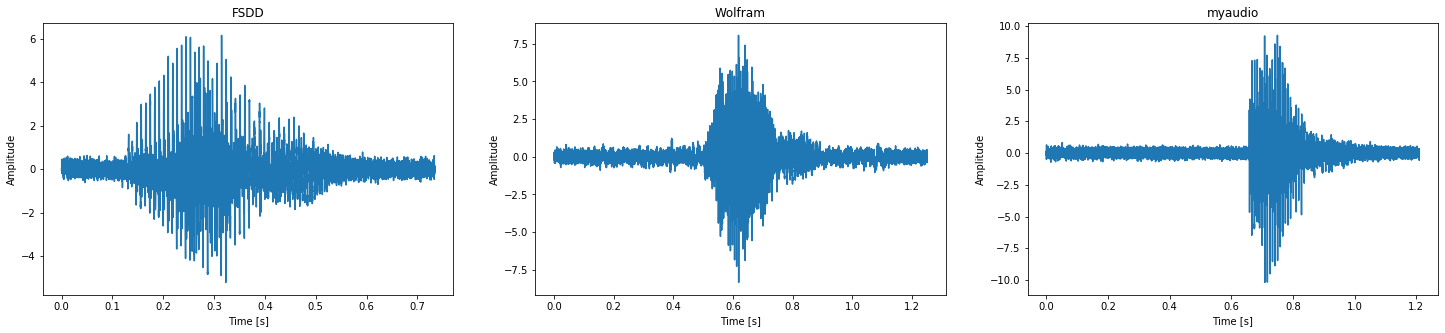

In [ ]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(25, 5)
axs[0].set(title='FSDD', xlabel="Time [s]", ylabel="Amplitude")
axs[1].set(title='Wolfram', xlabel="Time [s]", ylabel="Amplitude")
axs[2].set(title='myaudio', xlabel="Time [s]", ylabel="Amplitude")
plot_waveform(sample_rate1, wave1, axs[0])
plot_waveform(sample_rate2, wave2, axs[1])
plot_waveform(sample_rate3, wave3, axs[2])

## So sánh spectrogram

In [ ]:
def plot_melspec(sr, y, ax):
  S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40, fmax=8000)
  S_dB = librosa.power_to_db(S, ref=np.max)
  img = librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=sr,
                          ax=ax)
  return img

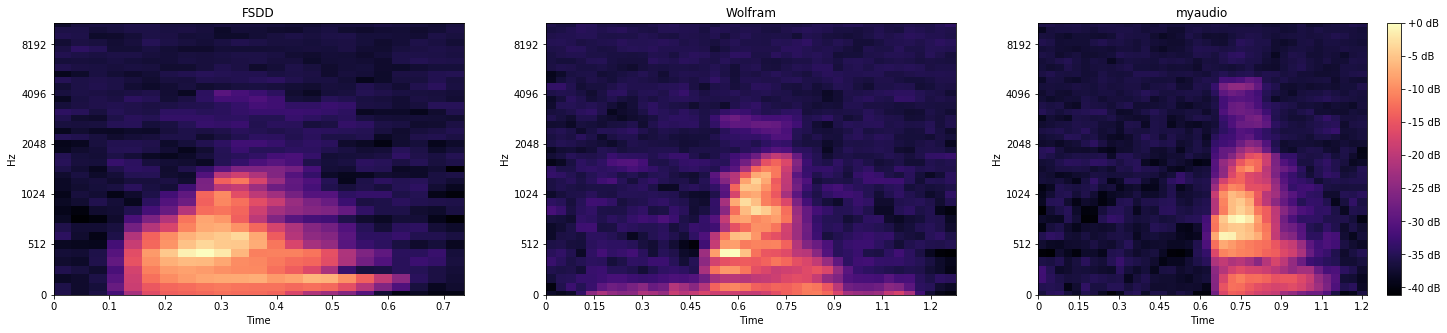

In [ ]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(25, 5)
axs[0].set(title='FSDD', xlabel="Time [s]", ylabel="Amplitude")
axs[1].set(title='Wolfram', xlabel="Time [s]", ylabel="Amplitude")
axs[2].set(title='myaudio', xlabel="Time [s]", ylabel="Amplitude")
img = plot_melspec(sample_rate1, wave1, axs[0])
fig.colorbar(img, format='%+2.0f dB')
plot_melspec(sample_rate2, wave2, axs[1])
plot_melspec(sample_rate3, wave3, axs[2])
fig.show()

Ghi chú: dễ dàng nhìn thấy điểm giống nhau ở vùng sáng có hình viên socola Hershey's Kisses

![](http://cdn.shopify.com/s/files/1/0972/7116/products/Hershey_s_Milk_Chocolate_Kisses_600x.jpg?v=1576258899)

## So sánh MFCC

In [ ]:
def plot_mfcc(sr, y, ax):
  mfccs = extract_mfcc(y, sr).T
  rdgn = sns.diverging_palette(h_neg=235, h_pos=4, s=80, l=46, sep=3, as_cmap=True)
  sns.heatmap(mfccs, cmap=rdgn, center=0.00, cbar=True, ax=ax, vmax=1/6, vmin=-1/6)
  ax.invert_yaxis()

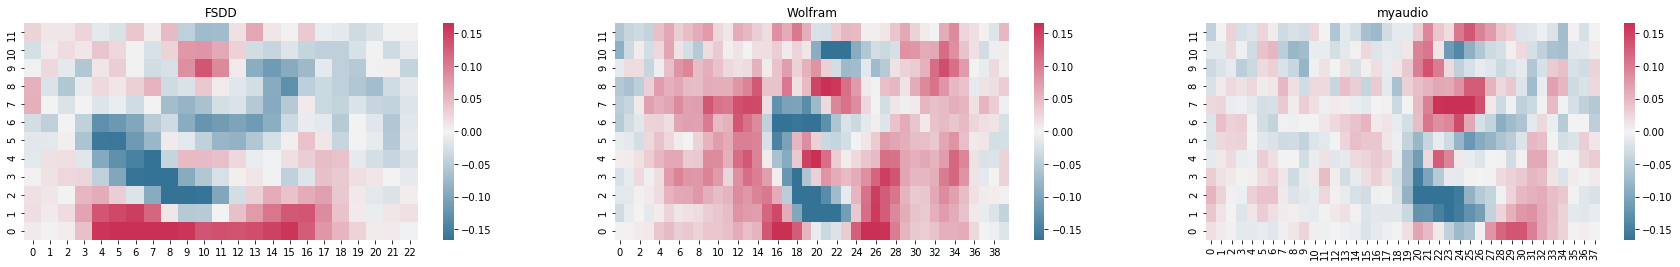

In [ ]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(30, 4)
axs[0].set(title='FSDD')
plot_mfcc(sample_rate1, wave1, axs[0])
axs[1].set(title='Wolfram')
plot_mfcc(sample_rate2, wave2, axs[1])
axs[2].set(title='myaudio')
plot_mfcc(sample_rate3, wave3, axs[2])
fig.show()

## So sánh chroma

In [ ]:
def plot_chroma(sr, y, ax):
  chroma = librosa.feature.chroma_stft(y=y, sr=sr)
  img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax)
  return img

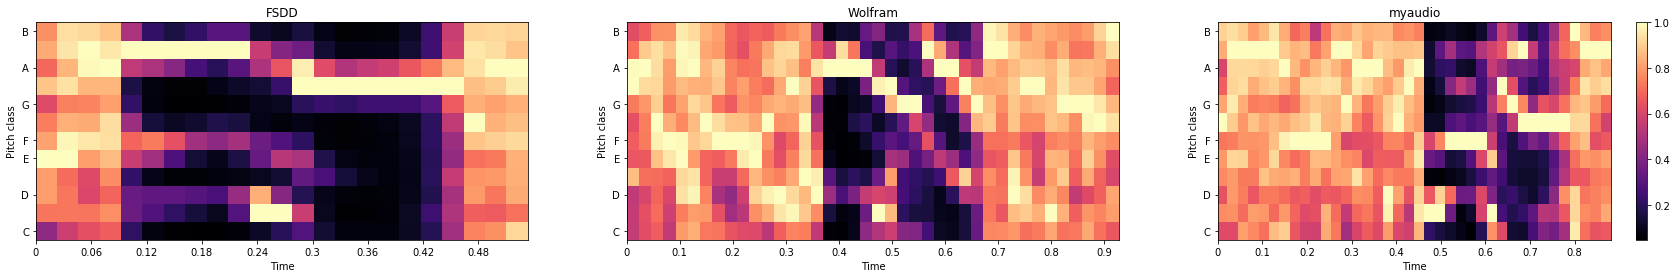

In [ ]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(30, 4)
axs[0].set(title='FSDD')
plot_chroma(sample_rate1, wave1, axs[0])
axs[1].set(title='Wolfram')
plot_chroma(sample_rate2, wave2, axs[1])
axs[2].set(title='myaudio')
img = plot_chroma(sample_rate3, wave3, axs[2])
fig.colorbar(img)
fig.show()

In [ ]:
def plot_rms(sr, y, ax):
  rms = librosa.feature.rms(y=y)[0]
  times = range(len(rms))

  ax.plot(times, rms)
  ax.axhline(0.02, color='r', alpha=0.5)
  ax.grid(True)
  ax.set(xlabel='Time', ylabel='RMS')

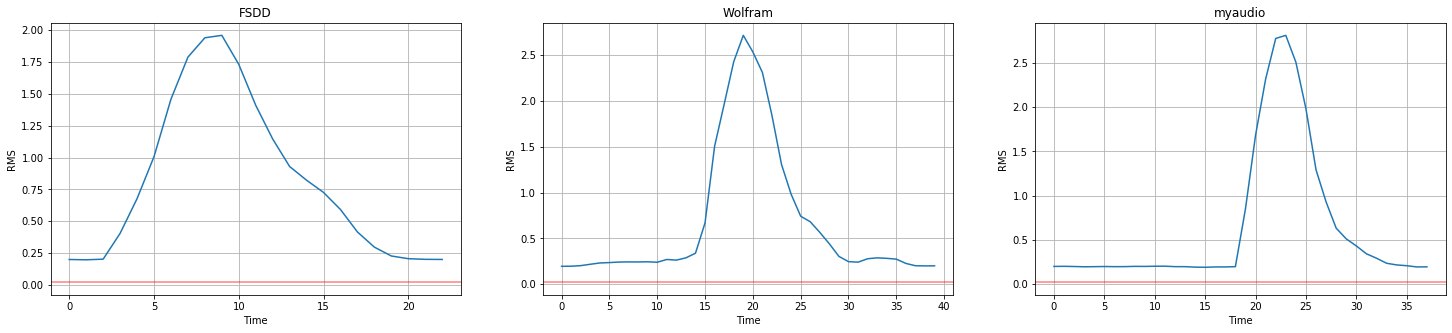

In [ ]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(25, 5)
axs[0].set(title='FSDD', xlabel="Time [s]", ylabel="Amplitude")
axs[1].set(title='Wolfram', xlabel="Time [s]", ylabel="Amplitude")
axs[2].set(title='myaudio', xlabel="Time [s]", ylabel="Amplitude")
plot_rms(sample_rate1, wave1, axs[0])
plot_rms(sample_rate2, wave2, axs[1])
plot_rms(sample_rate3, wave3, axs[2])

In [ ]:
def plot_rms_p(sr, y, ax):
  rms = librosa.feature.rms(y=y)[0]
  times = range(len(rms))
  r_normalized = (rms - np.mean(rms)) / np.std(rms)
  p = np.exp(r_normalized) / (1 + np.exp(r_normalized))
  ax.plot(times, p, label='P[V=1|x]')
  ax.axhline(0.4, color='r', alpha=0.5, label='Descision threshold')
  ax.set(xlabel='Time')
  ax.grid(True)
  ax.legend();

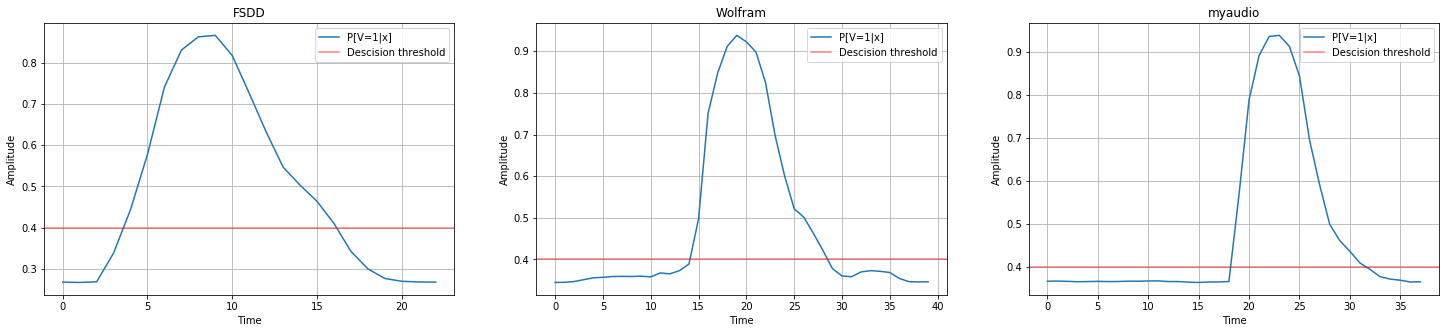

In [ ]:
fig, axs = plt.subplots(ncols=3)
fig.set_size_inches(25, 5)
axs[0].set(title='FSDD', xlabel="Time [s]", ylabel="Amplitude")
axs[1].set(title='Wolfram', xlabel="Time [s]", ylabel="Amplitude")
axs[2].set(title='myaudio', xlabel="Time [s]", ylabel="Amplitude")
plot_rms_p(sample_rate1, wave1, axs[0])
plot_rms_p(sample_rate2, wave2, axs[1])
plot_rms_p(sample_rate3, wave3, axs[2])

# Huấn luyện mô hình (có thể bỏ qua vì mô hình đã save trên drive)

## Hàm train mô hình

In [ ]:
def Generate_DiagGMM(full_fset, n_features, n_states=5, n_cmps=3):
  means = np.mean(full_fset, axis=0)
  stds = np.std(full_fset, axis=0)
  # initial values for all gaussian components
  np.random.seed(None)
  dist_init = np.random.random((n_states, n_cmps, n_features, 2))
  dist_init[..., 0] -= 0.5  # center means to 0.0
  #for feat_i in range(n_features):
      # random init mean in range [-std, std)
      #dist_init[..., feat_i, 0] *= 2 * stds[feat_i]
      #dist_init[..., feat_i, 0] += means[feat_i]
      # random init std in range 1std/n_components
      #dist_init[..., feat_i, 1] *= stds[feat_i] / n_cmps

  dists = tuple(
      GeneralMixtureModel(list(
          IndependentComponentsDistribution(tuple(
              NormalDistribution(*dist_init[state_i, cmp_i, feat_i, :])
              for feat_i in range(n_features)
          ))
          for cmp_i in range(n_cmps)
      ))
      if n_cmps > 1 else
      IndependentComponentsDistribution(tuple(
          NormalDistribution(*dist_init[state_i, 0, feat_i, :])
          for feat_i in range(n_features)
      ))
      for state_i in range(n_states)
  )
  return dists

In [ ]:
# Generate progressive HMM model
def left_right_GMMHMM(seed_sample, x_dim, n_states=10, n_modals=9, random=0):
  rng = np.random.RandomState(random)
  if random!=0:
    init_prob = lambda: rng.rand(1)[0]
    
  model = HiddenMarkovModel()
  states = [ ]
  for i, state_model in enumerate(Generate_DiagGMM(seed_sample, x_dim, n_states, n_modals)):
    state = State( state_model, name=f"H{i}" )
    model.add_state(state)
    states.append(state)
  model.add_transition(model.start, states[0], 1)
  for i in range(n_states-1):
    model.add_transition(states[i], states[i], 0.5)
    model.add_transition(states[i], states[i+1], 0.5)
  model.add_transition(states[n_states-1], states[n_states-1], 0.5)
  model.add_transition(states[n_states-1], model.end, 0.5)
  model.bake()
  return model

In [ ]:
def train_GMMHMM(dataset, input_dim, n_hidden_state, n_gauss_modal):
    GMMHMM_Models = dict()

    for label in dataset.keys():
        print(f"Training model detect {label}")
        model = left_right_GMMHMM(dataset[label][0], input_dim, n_hidden_state, n_gauss_modal)
        model.fit(dataset[label], verbose=True, multiple_check_input=False)  # get optimal parameters
        GMMHMM_Models[label] = model

    return GMMHMM_Models

## Hàm test mô hình

In [ ]:
# test model
def evaluateModel(testDataSet, model):
    if (len(testDataSet) == 0):
      return
    score_cnt = 0
    total = 0
    for label in testDataSet.keys():
        features = testDataSet[label]
        total += len(features)
        for sample in features:
            scoreList = {}
            for model_label in model.keys():
                score = model[model_label].log_probability(sample)
                scoreList[model_label] = score
            predict = max(scoreList, key=scoreList.get)
            if predict == label:
                score_cnt += 1
        print(f"{label}: ({score_cnt}/{total})")

    print("Final recognition rate is %.2f"%(100.0*score_cnt/total), "%")

## Đọc và tiền xử lý data

In [ ]:
# prepare data for training
master_path = 'fsdd'

trainDir = master_path + '/train_audio/'
trainDataSet_fsdd = buildDataSet(trainDir)
print("Finish prepare the training data")

# prepare data for testing
testDir = master_path + '/test_audio/'
testDataSet_fsdd = buildDataSet(testDir)
print("Finish prepare the test data")

Finish prepare the training data
Finish prepare the test data


In [ ]:
# prepare data for training
master_path = 'wolfram'

trainDir = master_path + '/train_audio/'
trainDataSet_wolfram = buildDataSet(trainDir)
print("Finish prepare the training data")

# prepare data for testing
testDir = master_path + '/test_audio/'
testDataSet_wolfram = buildDataSet(testDir)
print("Finish prepare the test data")

Finish prepare the training data
Finish prepare the test data


In [ ]:
trainDataSet = trainDataSet_fsdd
if wolfram_split > 0:
  for label in trainDataSet_fsdd.keys():
    trainDataSet[label] = trainDataSet_fsdd[label] + trainDataSet_wolfram[label]

## **Mô hình 1**
- 10 hiddent states
- Multivariate Diagonal Gauss cho emission probs

In [ ]:
for label in trainDataSet.keys():
  print(min(map(len, trainDataSet[label])))

10
10
10
10
10
10
10
10
10
10


In [ ]:
%%time
# train
hmmModels = train_GMMHMM(trainDataSet, n_mfcc_features,10,n_mixtures)
print("Finish training of the GMM_HMM models for digits 0-9")

Training model detect 1
[1] Improvement: 919280.2278133569	Time (s): 0.03013
[2] Improvement: 1062.4727608808025	Time (s): 0.03052
[3] Improvement: 280.8041033836489	Time (s): 0.03473
[4] Improvement: 403.06999091769103	Time (s): 0.03751
[5] Improvement: 134.34500591788674	Time (s): 0.03558
[6] Improvement: 5.8657523617875995	Time (s): 0.0317
[7] Improvement: 0.6953585355513496	Time (s): 0.03111
[8] Improvement: 0.17264344049908686	Time (s): 0.03369
[9] Improvement: 0.05278321048535872	Time (s): 0.03869
[10] Improvement: 0.015965714206686243	Time (s): 0.03565
[11] Improvement: 0.004620021718437783	Time (s): 0.03597
[12] Improvement: 0.0022043318167561665	Time (s): 0.03131
[13] Improvement: 0.21555849905416835	Time (s): 0.03204
[14] Improvement: 19.94325952757208	Time (s): 0.03164
[15] Improvement: 95.0243245412712	Time (s): 0.04445
[16] Improvement: 60.76943886638037	Time (s): 0.03545
[17] Improvement: 102.39038134693692	Time (s): 0.04341
[18] Improvement: 107.24698479917424	Time (s): 

In [ ]:
print("Evaluate on train set")
evaluateModel(trainDataSet, hmmModels)
print("Evaluate on rest of FSDD set")
evaluateModel(testDataSet_fsdd, hmmModels)
print("Evaluate on wolfram test set")
evaluateModel(testDataSet_wolfram, hmmModels)

Evaluate on train set
1: (104/117)
2: (193/233)
7: (280/327)
6: (393/470)
8: (489/599)
0: (608/721)
9: (707/840)
5: (835/970)
3: (918/1074)
4: (1031/1200)
Final recognition rate is 85.92 %
Evaluate on rest of FSDD set
0: (169/178)
3: (306/374)
9: (460/555)
7: (655/761)
4: (813/935)
5: (979/1105)
8: (1086/1276)
1: (1255/1459)
2: (1389/1643)
6: (1508/1800)
Final recognition rate is 83.78 %
Evaluate on wolfram test set
4: (1377/2372)
8: (2428/4724)
7: (3365/7101)
1: (5037/9471)
2: (6072/11844)
3: (7246/14200)
6: (7762/16569)
0: (9110/18945)
5: (10809/21302)
9: (12719/23666)
Final recognition rate is 53.74 %


In [ ]:
# lưu lại model
for model_label in hmmModels.keys():
  file = drive.CreateFile({'title': f'hmm[{model_label}]_{n_mfcc_features}_10_{n_mixtures}[{experiment_id}].json', 'parents': [{'id': '1QPUr4vwYHu3n9iH3iQmnvDUt2Dgx4V3Y'}]})
  file.SetContentString(hmmModels[model_label].to_json())
  file.Upload()

## **Mô hình 2**
- 5 hiddent states
- Multivariate Diagonal Gauss cho emission probs

In [ ]:
%%time
# train
hmmModels = train_GMMHMM(trainDataSet, n_mfcc_features,5,n_mixtures)
print("Finish training of the GMM_HMM models for digits 0-9")

Training model detect 1
[1] Improvement: 163399.48575321544	Time (s): 0.01866
[2] Improvement: 1832.6116465712548	Time (s): 0.0188
[3] Improvement: 399.8200278078875	Time (s): 0.01931
[4] Improvement: 447.2505444289709	Time (s): 0.01917
[5] Improvement: 370.4122327077057	Time (s): 0.01902
[6] Improvement: 309.81793200506945	Time (s): 0.01903
[7] Improvement: 161.06362600144348	Time (s): 0.01862
[8] Improvement: 81.7299798977474	Time (s): 0.01905
[9] Improvement: 33.82225740957074	Time (s): 0.01881
[10] Improvement: 17.805854396443465	Time (s): 0.02266
[11] Improvement: 11.280767164207646	Time (s): 0.01812
[12] Improvement: 7.5255764599569375	Time (s): 0.01803
[13] Improvement: 6.958772955040331	Time (s): 0.02848
[14] Improvement: 10.355287411715835	Time (s): 0.01898
[15] Improvement: 11.062720816014917	Time (s): 0.01906
[16] Improvement: 7.600260748935398	Time (s): 0.01879
[17] Improvement: 5.5532768297271105	Time (s): 0.02124
[18] Improvement: 5.409745731740259	Time (s): 0.01927
[19] 

In [ ]:
print("Evaluate on train set")
evaluateModel(trainDataSet, hmmModels)
print("Evaluate on rest of FSDD set")
evaluateModel(testDataSet_fsdd, hmmModels)
print("Evaluate on wolfram test set")
evaluateModel(testDataSet_wolfram, hmmModels)

Evaluate on train set
1: (97/117)
2: (177/233)
7: (263/327)
6: (364/470)
8: (471/599)
0: (592/721)
9: (693/840)
5: (817/970)
3: (909/1074)
4: (1026/1200)
Final recognition rate is 85.50 %
Evaluate on rest of FSDD set
0: (172/178)
3: (333/374)
9: (483/555)
7: (669/761)
4: (833/935)
5: (993/1105)
8: (1138/1276)
1: (1296/1459)
2: (1431/1643)
6: (1526/1800)
Final recognition rate is 84.78 %
Evaluate on wolfram test set
4: (1370/2372)
8: (2774/4724)
7: (3716/7101)
1: (5576/9471)
2: (6560/11844)
3: (7738/14200)
6: (8359/16569)
0: (9568/18945)
5: (11273/21302)
9: (12857/23666)
Final recognition rate is 54.33 %


In [ ]:
# lưu lại model
for model_label in hmmModels.keys():
  file = drive.CreateFile({'title': f'hmm[{model_label}]_{n_mfcc_features}_5_{n_mixtures}[{experiment_id}].json', 'parents': [{'id': '1QPUr4vwYHu3n9iH3iQmnvDUt2Dgx4V3Y'}]})
  file.SetContentString(hmmModels[model_label].to_json())
  file.Upload()

## **Mô hình 3**
- 3 hiddent states
- Multivariate Diagonal Gauss cho emission probs

In [ ]:
%%time
# train
hmmModels = train_GMMHMM(trainDataSet, n_mfcc_features,3,n_mixtures)
print("Finish training of the GMM_HMM models for digits 0-9")

Training model detect 1
[1] Improvement: 185116.64007605505	Time (s): 0.01266
[2] Improvement: 820.0249509345304	Time (s): 0.01351
[3] Improvement: 366.45508911067736	Time (s): 0.0127
[4] Improvement: 228.7109680932772	Time (s): 0.01303
[5] Improvement: 160.86305686773267	Time (s): 0.01264
[6] Improvement: 32.982785850937944	Time (s): 0.01264
[7] Improvement: 16.087274471850833	Time (s): 0.01259
[8] Improvement: 5.736385392781813	Time (s): 0.01258
[9] Improvement: 2.120113494383986	Time (s): 0.01262
[10] Improvement: 0.5099869535479229	Time (s): 0.01573
[11] Improvement: 0.1335573785327142	Time (s): 0.01337
[12] Improvement: 0.03931138006737456	Time (s): 0.01322
[13] Improvement: 0.012877178058261052	Time (s): 0.01334
[14] Improvement: 0.004825046431506053	Time (s): 0.01699
[15] Improvement: 0.0020801550417672843	Time (s): 0.01401
[16] Improvement: 0.0010031490382971242	Time (s): 0.01373
[17] Improvement: 0.0005203345644986257	Time (s): 0.01363
[18] Improvement: 0.0002815227344399318	T

In [ ]:
print("Evaluate on train set")
evaluateModel(trainDataSet, hmmModels)
print("Evaluate on rest of FSDD set")
evaluateModel(testDataSet_fsdd, hmmModels)
print("Evaluate on wolfram test set")
evaluateModel(testDataSet_wolfram, hmmModels)

Evaluate on train set
1: (89/117)
2: (187/233)
7: (277/327)
6: (335/470)
8: (439/599)
0: (544/721)
9: (641/840)
5: (766/970)
3: (841/1074)
4: (949/1200)
Final recognition rate is 79.08 %
Evaluate on rest of FSDD set
0: (142/178)
3: (265/374)
9: (410/555)
7: (601/761)
4: (756/935)
5: (922/1105)
8: (1050/1276)
1: (1198/1459)
2: (1347/1643)
6: (1405/1800)
Final recognition rate is 78.06 %
Evaluate on wolfram test set
4: (1095/2372)
8: (2018/4724)
7: (2954/7101)
1: (4662/9471)
2: (5580/11844)
3: (6536/14200)
6: (6833/16569)
0: (7460/18945)
5: (9128/21302)
9: (10905/23666)
Final recognition rate is 46.08 %


In [ ]:
# lưu lại model
for model_label in hmmModels.keys():
  file = drive.CreateFile({'title': f'hmm[{model_label}]_{n_mfcc_features}_3_{n_mixtures}[{experiment_id}].json', 'parents': [{'id': '1QPUr4vwYHu3n9iH3iQmnvDUt2Dgx4V3Y'}]})
  file.SetContentString(hmmModels[model_label].to_json())
  file.Upload()